# Import

In [ ]:
from tensorflow import keras
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import image_dataset_from_directory
from joblib import dump, load

# Data importeren

Importeren van de data uit drive,
vul de authorization code in die verkregen wordt via de link of er wordt al direct een scherm opgebracht waar je kan inloggen.

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
!ln -s "/gdrive/My Drive/Schilderijen-Classificeren_Arthur-Huys/datasets" "/content/datasets"

Mounted at /gdrive


In [ ]:
import shutil
shutil.unpack_archive('datasets/Picasso_Rubens_VanGogh_400_100_100.zip','.','zip')

# creëren datasets

Bij het creëren van deze datasets moet de class_mode verandert naar categorical omdat we nu met multi class data werken (3 verschillende labels).

In [ ]:
train_dataset = image_dataset_from_directory(
    "Picasso_Rubens_VanGogh_400_100_100/train",
    image_size=(224, 224),
    batch_size=32,
    label_mode="categorical")

validation_dataset = image_dataset_from_directory(
    "Picasso_Rubens_VanGogh_400_100_100/validation",
    image_size=(224, 224),
    batch_size=32,
    label_mode="categorical")

test_dataset = image_dataset_from_directory(
    "Picasso_Rubens_VanGogh_400_100_100/test",
    image_size=(224, 224),
    batch_size=32,
    label_mode="categorical")

Found 1200 files belonging to 3 classes.
Found 300 files belonging to 3 classes.
Found 300 files belonging to 3 classes.


In [ ]:
data_augmentation = keras.Sequential(
    [layers.RandomFlip("horizontal"),
     layers.RandomRotation(0.1),
     layers.RandomZoom(0.2),])

# EfficientNet B0

Omdat we nu werken met multi-class classification voegen we 2 velden toe wanneer we het model creëren, deze velden zijn classes en classifier_activation.

* classes staat voor hoeveel klassen het model moet classificeren.
* classifier_activation is de manier waarop de data geclassificeerd zal worden.

In [ ]:
base_model = keras.applications.EfficientNetB0(
    input_shape = (224, 224, 3),
    include_top = False,
    weights = 'imagenet',
    classes=3,
    classifier_activation="softmax")

for layer in base_model.layers:
    layer.trainable = False

Doordat we nu werken met multi class bestaat de output uit 3 waarden, dus moeten we de dense aanpassen naar:

```
Dense(3, activation="softmax")(x)
```



In [ ]:
inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = keras.applications.efficientnet.preprocess_input(x)
x = base_model(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(3, activation="softmax")(x)
model = keras.Model(inputs, outputs)

Ik heb hier ook de loss verandert naar een categorical_crossentropy 

In [ ]:
model.compile(loss="categorical_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [ ]:
callbacks = [keras.callbacks.ModelCheckpoint(
    filepath="feature_extraction.keras",
    save_best_only=True,
    monitor="val_loss")]

Het trainen van dit model duurt veel langer dan de vorige modellen, daarom gebruiken we maar een aantal epochs van 40.

In [ ]:
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
38/38 [==============================] - ETA: 0s - loss: 12.4114 - accuracy: 0.7908

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


38/38 [==============================] - 26s 363ms/step - loss: 12.4114 - accuracy: 0.7908 - val_loss: 15.0976 - val_accuracy: 0.7500
Epoch 2/30
38/38 [==============================] - 10s 241ms/step - loss: 5.8474 - accuracy: 0.8675 - val_loss: 10.1187 - val_accuracy: 0.8333
Epoch 3/30
38/38 [==============================] - 10s 240ms/step - loss: 2.3676 - accuracy: 0.9358 - val_loss: 9.4374 - val_accuracy: 0.8667
Epoch 4/30
38/38 [==============================] - 10s 242ms/step - loss: 3.1137 - accuracy: 0.9208 - val_loss: 6.8930 - val_accuracy: 0.8933
Epoch 5/30
38/38 [==============================] - 9s 221ms/step - loss: 2.7178 - accuracy: 0.9367 - val_loss: 8.1224 - val_accuracy: 0.9033
Epoch 6/30
38/38 [==============================] - 10s 227ms/step - loss: 2.2903 - accuracy: 0.9433 - val_loss: 10.4550 - val_accuracy: 0.8467
Epoch 7/30
38/38 [==============================] - 9s 221ms/step - loss: 2.4479 - accuracy: 0.9425 - val_loss: 8.9105 - val_accuracy: 0.8767
Epoch 8/

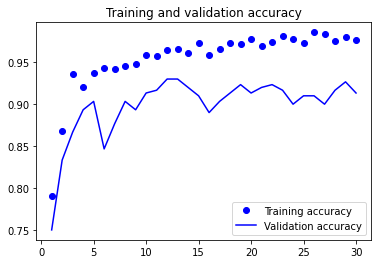

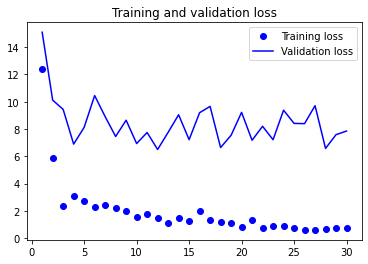

In [ ]:
import matplotlib.pylab as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
test_model = keras.models.load_model("feature_extraction.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

10/10 [==============================] - 4s 130ms/step - loss: 5.6864 - accuracy: 0.9033
Test accuracy: 0.903


We zien dat de accuracy al heel wat daalt door te veranderen van binaire classifcatie naar multi class classification, wat wel logisch is.

We kunnen nu eens testen wat het verschil is wanneer we een andere optimizer gebruiken, zoals adam en sgd.

# EfficientNet optimizer -> adam

In [ ]:
base_model = keras.applications.EfficientNetB0(
    input_shape = (224, 224, 3),
    include_top = False,
    weights = 'imagenet',
    classes=3,
    classifier_activation="softmax")

for layer in base_model.layers:
    layer.trainable = False

In [ ]:
inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = keras.applications.efficientnet.preprocess_input(x)
x = base_model(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(3, activation="softmax")(x)
model = keras.Model(inputs, outputs)

Veranderen van optimizer naar "adam"

In [ ]:
model.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [ ]:
callbacks = [keras.callbacks.ModelCheckpoint(
    filepath="feature_extraction.keras",
    save_best_only=True,
    monitor="val_loss")]

In [ ]:
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
38/38 [==============================] - ETA: 0s - loss: 7.8044 - accuracy: 0.7825

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


38/38 [==============================] - 20s 282ms/step - loss: 7.8044 - accuracy: 0.7825 - val_loss: 8.0070 - val_accuracy: 0.8167
Epoch 2/30
38/38 [==============================] - 10s 234ms/step - loss: 3.7541 - accuracy: 0.8967 - val_loss: 4.9803 - val_accuracy: 0.8967
Epoch 3/30
38/38 [==============================] - 9s 211ms/step - loss: 3.5784 - accuracy: 0.9133 - val_loss: 6.8429 - val_accuracy: 0.8667
Epoch 4/30
38/38 [==============================] - 9s 212ms/step - loss: 2.2541 - accuracy: 0.9367 - val_loss: 5.9692 - val_accuracy: 0.9067
Epoch 5/30
38/38 [==============================] - 9s 213ms/step - loss: 1.6528 - accuracy: 0.9442 - val_loss: 6.8154 - val_accuracy: 0.8900
Epoch 6/30
38/38 [==============================] - 9s 209ms/step - loss: 1.6386 - accuracy: 0.9467 - val_loss: 6.1425 - val_accuracy: 0.9000
Epoch 7/30
38/38 [==============================] - 9s 211ms/step - loss: 1.3074 - accuracy: 0.9558 - val_loss: 7.2967 - val_accuracy: 0.8833
Epoch 8/30
38/3

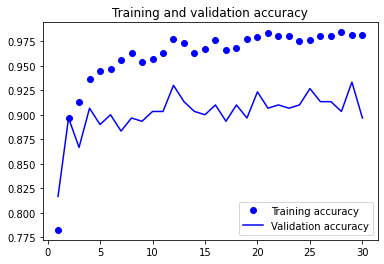

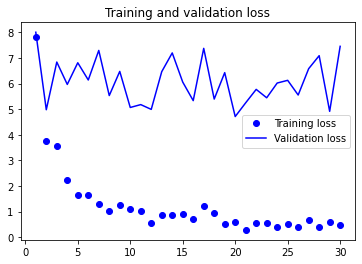

In [ ]:
import matplotlib.pylab as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
test_model = keras.models.load_model("feature_extraction.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

10/10 [==============================] - 4s 126ms/step - loss: 4.4274 - accuracy: 0.9167
Test accuracy: 0.917


Hier zien we dat adam een betere optimizer is want we hebben bijna een increase van 2%.

# EfficientNet optimizer -> sgd

In [ ]:
base_model = keras.applications.EfficientNetB0(
    input_shape = (224, 224, 3),
    include_top = False,
    weights = 'imagenet',
    classes=3,
    classifier_activation="softmax")

for layer in base_model.layers:
    layer.trainable = False

In [ ]:
inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = keras.applications.efficientnet.preprocess_input(x)
x = base_model(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(3, activation="softmax")(x)
model = keras.Model(inputs, outputs)

Veranderen van optimizer naar "sgd"

In [ ]:
model.compile(loss="categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

In [ ]:
callbacks = [keras.callbacks.ModelCheckpoint(
    filepath="feature_extraction.keras",
    save_best_only=True,
    monitor="val_loss")]

In [ ]:
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
38/38 [==============================] - ETA: 0s - loss: 1.6632 - accuracy: 0.7692

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


38/38 [==============================] - 18s 268ms/step - loss: 1.6632 - accuracy: 0.7692 - val_loss: 0.9393 - val_accuracy: 0.8633
Epoch 2/30
38/38 [==============================] - 9s 209ms/step - loss: 0.5200 - accuracy: 0.9033 - val_loss: 1.4623 - val_accuracy: 0.8033
Epoch 3/30
38/38 [==============================] - 9s 222ms/step - loss: 0.3312 - accuracy: 0.9233 - val_loss: 0.7439 - val_accuracy: 0.8833
Epoch 4/30
38/38 [==============================] - 10s 229ms/step - loss: 0.2989 - accuracy: 0.9333 - val_loss: 0.6343 - val_accuracy: 0.9000
Epoch 5/30
38/38 [==============================] - 9s 207ms/step - loss: 0.1588 - accuracy: 0.9533 - val_loss: 0.9282 - val_accuracy: 0.8633
Epoch 6/30
38/38 [==============================] - 10s 229ms/step - loss: 0.1715 - accuracy: 0.9558 - val_loss: 0.6014 - val_accuracy: 0.9067
Epoch 7/30
38/38 [==============================] - 10s 228ms/step - loss: 0.1599 - accuracy: 0.9608 - val_loss: 0.5545 - val_accuracy: 0.9067
Epoch 8/30
38

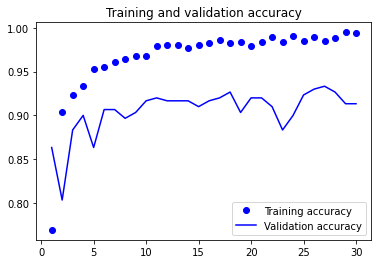

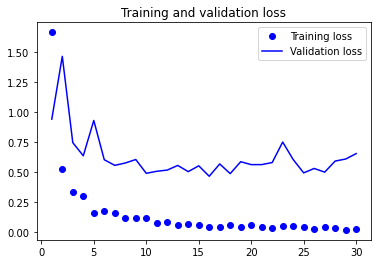

In [ ]:
import matplotlib.pylab as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
test_model = keras.models.load_model("feature_extraction.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

10/10 [==============================] - 4s 126ms/step - loss: 0.3400 - accuracy: 0.9267
Test accuracy: 0.927


Hier zien we dat sgd nog een betere optimizer is want we hebben nu bijna een increase van 3%, daarom zal ik sgd gebruiken in de volgende modellen.

# EfficientNet batch normalization

Batch normalization zorft ervoor dat de weights genormaliseerd worden, geen buitenliggende weights met extreme hoge waarden meer. De data binnen in het netwerk wordt daarom ook kleiner. Het zou er ook voor moeten zorgen da het netwerk sneller trained.

In [ ]:
base_model = keras.applications.EfficientNetB0(
    input_shape = (224, 224, 3),
    include_top = False,
    weights = 'imagenet',
    classes=3,
    classifier_activation="softmax")

for layer in base_model.layers:
    layer.trainable = False

16719872/16705208 [==============================] - 0s 0us/step


We voegen de regel voor batch normalization toe voor de dropout.


```
x = layers.BatchNormalization()(x)
```



In [ ]:
inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = keras.applications.efficientnet.preprocess_input(x)
x = base_model(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(3, activation="softmax")(x)
model = keras.Model(inputs, outputs)

In [ ]:
model.compile(loss="categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

In [ ]:
callbacks = [keras.callbacks.ModelCheckpoint(
    filepath="feature_extraction.keras",
    save_best_only=True,
    monitor="val_loss")]

In [ ]:
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
38/38 [==============================] - ETA: 0s - loss: 0.7194 - accuracy: 0.8033

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


38/38 [==============================] - 28s 305ms/step - loss: 0.7194 - accuracy: 0.8033 - val_loss: 0.6241 - val_accuracy: 0.8867
Epoch 2/30
38/38 [==============================] - 10s 231ms/step - loss: 0.3052 - accuracy: 0.9067 - val_loss: 0.4639 - val_accuracy: 0.9100
Epoch 3/30
38/38 [==============================] - 10s 229ms/step - loss: 0.2155 - accuracy: 0.9217 - val_loss: 0.4199 - val_accuracy: 0.9000
Epoch 4/30
38/38 [==============================] - 10s 230ms/step - loss: 0.1852 - accuracy: 0.9408 - val_loss: 0.3663 - val_accuracy: 0.9200
Epoch 5/30
38/38 [==============================] - 9s 216ms/step - loss: 0.1669 - accuracy: 0.9433 - val_loss: 0.4478 - val_accuracy: 0.8933
Epoch 6/30
38/38 [==============================] - 9s 216ms/step - loss: 0.1112 - accuracy: 0.9658 - val_loss: 0.4411 - val_accuracy: 0.9100
Epoch 7/30
38/38 [==============================] - 10s 238ms/step - loss: 0.1212 - accuracy: 0.9625 - val_loss: 0.4491 - val_accuracy: 0.8967
Epoch 8/30
3

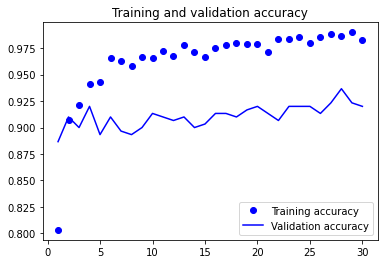

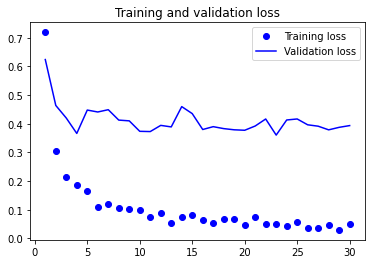

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
test_model = keras.models.load_model("feature_extraction.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

10/10 [==============================] - 4s 127ms/step - loss: 0.2031 - accuracy: 0.9367
Test accuracy: 0.937


Ook zien we dat dit een positief effect heeft op ons model, er is weer een verhoging van 1%.

# EfficientNet batch size 64

## creëren datasets

Veranderen van batch size naar 64

In [ ]:
train_dataset = image_dataset_from_directory(
    "Picasso_Rubens_VanGogh_400_100_100/train",
    image_size=(224, 224),
    batch_size=64,
    label_mode="categorical")

validation_dataset = image_dataset_from_directory(
    "Picasso_Rubens_VanGogh_400_100_100/validation",
    image_size=(224, 224),
    batch_size=64,
    label_mode="categorical")

test_dataset = image_dataset_from_directory(
    "Picasso_Rubens_VanGogh_400_100_100/test",
    image_size=(224, 224),
    batch_size=64,
    label_mode="categorical")

Found 1200 files belonging to 3 classes.
Found 300 files belonging to 3 classes.
Found 300 files belonging to 3 classes.


In [ ]:
data_augmentation = keras.Sequential(
    [layers.RandomFlip("horizontal"),
     layers.RandomRotation(0.1),
     layers.RandomZoom(0.2),])

## Model

In [ ]:
base_model = keras.applications.EfficientNetB0(
    input_shape = (224, 224, 3),
    include_top = False,
    weights = 'imagenet',
    classes=3,
    classifier_activation="softmax")

for layer in base_model.layers:
    layer.trainable = False

In [ ]:
inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = keras.applications.efficientnet.preprocess_input(x)
x = base_model(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(3, activation="softmax")(x)
model = keras.Model(inputs, outputs)

In [ ]:
model.compile(loss="categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

In [ ]:
callbacks = [keras.callbacks.ModelCheckpoint(
    filepath="feature_extraction.keras",
    save_best_only=True,
    monitor="val_loss")]

In [ ]:
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
19/19 [==============================] - ETA: 0s - loss: 0.6251 - accuracy: 0.8067

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


19/19 [==============================] - 22s 648ms/step - loss: 0.6251 - accuracy: 0.8067 - val_loss: 0.5353 - val_accuracy: 0.8467
Epoch 2/30
19/19 [==============================] - 11s 462ms/step - loss: 0.2826 - accuracy: 0.9008 - val_loss: 0.4307 - val_accuracy: 0.9067
Epoch 3/30
19/19 [==============================] - 10s 456ms/step - loss: 0.1765 - accuracy: 0.9308 - val_loss: 0.3706 - val_accuracy: 0.9100
Epoch 4/30
19/19 [==============================] - 10s 429ms/step - loss: 0.1439 - accuracy: 0.9492 - val_loss: 0.5583 - val_accuracy: 0.8900
Epoch 5/30
19/19 [==============================] - 10s 430ms/step - loss: 0.0923 - accuracy: 0.9675 - val_loss: 0.4540 - val_accuracy: 0.9000
Epoch 6/30
19/19 [==============================] - 10s 427ms/step - loss: 0.1104 - accuracy: 0.9675 - val_loss: 0.4661 - val_accuracy: 0.8933
Epoch 7/30
19/19 [==============================] - 10s 426ms/step - loss: 0.0738 - accuracy: 0.9717 - val_loss: 0.4162 - val_accuracy: 0.8967
Epoch 8/30

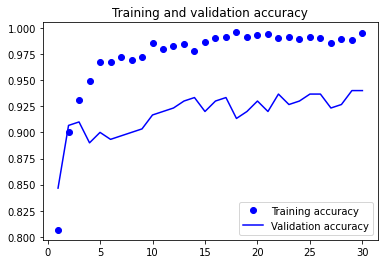

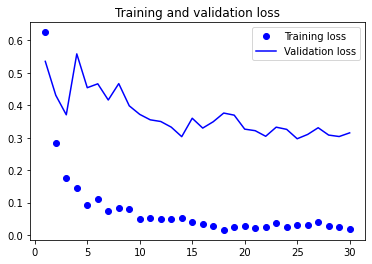

In [ ]:
import matplotlib.pylab as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
test_model = keras.models.load_model("feature_extraction.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

5/5 [==============================] - 4s 229ms/step - loss: 0.2434 - accuracy: 0.9333
Test accuracy: 0.933


We zien dat dit geen positief effect heeft op het model.

# EfficientNet batch size 16

## creëren datasets

Veranderen van batch size naar 16

In [ ]:
train_dataset = image_dataset_from_directory(
    "Picasso_Rubens_VanGogh_400_100_100/train",
    image_size=(224, 224),
    batch_size=16,
    label_mode="categorical")

validation_dataset = image_dataset_from_directory(
    "Picasso_Rubens_VanGogh_400_100_100/validation",
    image_size=(224, 224),
    batch_size=16,
    label_mode="categorical")

test_dataset = image_dataset_from_directory(
    "Picasso_Rubens_VanGogh_400_100_100/test",
    image_size=(224, 224),
    batch_size=16,
    label_mode="categorical")

Found 1200 files belonging to 3 classes.
Found 300 files belonging to 3 classes.
Found 300 files belonging to 3 classes.


In [ ]:
data_augmentation = keras.Sequential(
    [layers.RandomFlip("horizontal"),
     layers.RandomRotation(0.1),
     layers.RandomZoom(0.2),])

## Model

In [ ]:
base_model = keras.applications.EfficientNetB0(
    input_shape = (224, 224, 3),
    include_top = False,
    weights = 'imagenet',
    classes=3,
    classifier_activation="softmax")

for layer in base_model.layers:
    layer.trainable = False

In [ ]:
inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = keras.applications.efficientnet.preprocess_input(x)
x = base_model(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(3, activation="softmax")(x)
model = keras.Model(inputs, outputs)

In [ ]:
model.compile(loss="categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

In [ ]:
callbacks = [keras.callbacks.ModelCheckpoint(
    filepath="feature_extraction.keras",
    save_best_only=True,
    monitor="val_loss")]

In [ ]:
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
75/75 [==============================] - ETA: 0s - loss: 0.8283 - accuracy: 0.8042

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


75/75 [==============================] - 20s 158ms/step - loss: 0.8283 - accuracy: 0.8042 - val_loss: 0.6599 - val_accuracy: 0.8833
Epoch 2/30
75/75 [==============================] - 9s 115ms/step - loss: 0.3312 - accuracy: 0.9008 - val_loss: 0.7367 - val_accuracy: 0.8900
Epoch 3/30
75/75 [==============================] - 10s 123ms/step - loss: 0.2041 - accuracy: 0.9250 - val_loss: 0.5179 - val_accuracy: 0.8967
Epoch 4/30
75/75 [==============================] - 9s 116ms/step - loss: 0.1664 - accuracy: 0.9467 - val_loss: 0.5368 - val_accuracy: 0.8867
Epoch 5/30
75/75 [==============================] - 9s 117ms/step - loss: 0.1693 - accuracy: 0.9392 - val_loss: 0.5221 - val_accuracy: 0.8833
Epoch 6/30
75/75 [==============================] - 10s 124ms/step - loss: 0.1841 - accuracy: 0.9367 - val_loss: 0.4880 - val_accuracy: 0.8867
Epoch 7/30
75/75 [==============================] - 10s 124ms/step - loss: 0.1306 - accuracy: 0.9525 - val_loss: 0.3855 - val_accuracy: 0.8967
Epoch 8/30
75

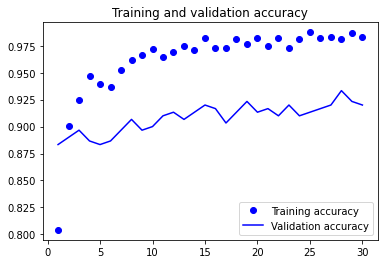

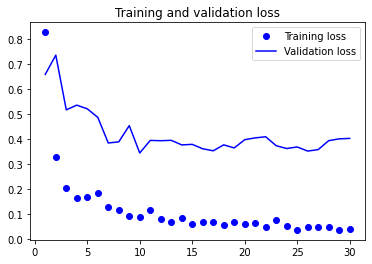

In [ ]:
import matplotlib.pylab as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
test_model = keras.models.load_model("feature_extraction.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

19/19 [==============================] - 4s 81ms/step - loss: 0.2947 - accuracy: 0.9167
Test accuracy: 0.917


We zien ook hier dat dit geen positief effect heeft op het model, dit is zelfs nog erger dan de 64 batch size.

# EfficientNet finetuning met 4 lagen

We kunnen een pretrained convnet finetunen door de laatste lagen van het model ook mee te trainen.

Dit doen we door alle lagen trainable te maken en de lagen die we niet willen trainen weer op untrainable te zetten.


```
base_model.trainable = True
for layer in base_model.layers[:-4]:
  layer.trainable = False
```



In [ ]:
base_model = keras.applications.EfficientNetB0(
    input_shape = (224, 224, 3),
    include_top = False,
    weights = 'imagenet',
    classes=3,
    classifier_activation="softmax")

base_model.trainable = True
for layer in base_model.layers[:-4]:
  layer.trainable = False

In [ ]:
inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = keras.applications.efficientnet.preprocess_input(x)
x = base_model(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(3, activation="softmax")(x)
model = keras.Model(inputs, outputs)

In [ ]:
model.compile(loss="categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

In [ ]:
callbacks = [keras.callbacks.ModelCheckpoint(
    filepath="feature_extraction.keras",
    save_best_only=True,
    monitor="val_loss")]

In [ ]:
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
38/38 [==============================] - ETA: 0s - loss: 0.6752 - accuracy: 0.7858

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


38/38 [==============================] - 21s 314ms/step - loss: 0.6752 - accuracy: 0.7858 - val_loss: 0.5926 - val_accuracy: 0.9000
Epoch 2/30
38/38 [==============================] - 10s 237ms/step - loss: 0.2993 - accuracy: 0.8983 - val_loss: 0.5784 - val_accuracy: 0.8900
Epoch 3/30
38/38 [==============================] - 10s 235ms/step - loss: 0.1925 - accuracy: 0.9392 - val_loss: 0.4521 - val_accuracy: 0.9200
Epoch 4/30
38/38 [==============================] - 11s 253ms/step - loss: 0.1526 - accuracy: 0.9408 - val_loss: 0.4403 - val_accuracy: 0.9200
Epoch 5/30
38/38 [==============================] - 10s 235ms/step - loss: 0.1260 - accuracy: 0.9633 - val_loss: 0.4263 - val_accuracy: 0.9133
Epoch 6/30
38/38 [==============================] - 10s 235ms/step - loss: 0.0854 - accuracy: 0.9700 - val_loss: 0.4179 - val_accuracy: 0.9100
Epoch 7/30
38/38 [==============================] - 9s 220ms/step - loss: 0.0746 - accuracy: 0.9708 - val_loss: 0.4361 - val_accuracy: 0.9033
Epoch 8/30


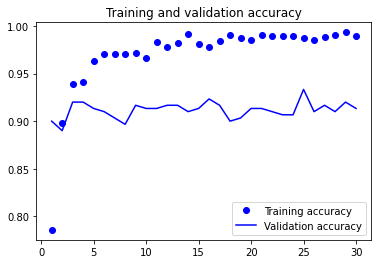

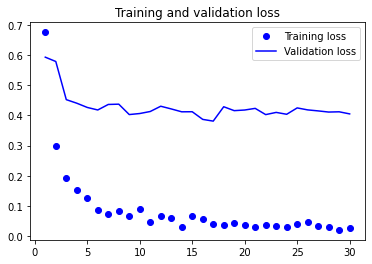

In [ ]:
import matplotlib.pylab as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
test_model = keras.models.load_model("feature_extraction.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

10/10 [==============================] - 4s 130ms/step - loss: 0.3042 - accuracy: 0.9100
Test accuracy: 0.910


We zien dat dit geen positief effect heeft op ons model, de accuracy is gezakt met bijna 4%.

# ResNet50

Nu ga ik ook nog eens het ResNet model toepassen op deze data, omdat we nu werken met multi class classification zou dit een verschil kunnen maken.

Het enige die moet aangepast worden is het type model zelf -> keras.applications.ResNet50

In [ ]:
base_model = keras.applications.ResNet50(
    include_top=False, 
    weights="imagenet",
    classes=3,
    classifier_activation="softmax")

for layer in base_model.layers:
    layer.trainable = False

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
data_augmentation = keras.Sequential(
    [layers.RandomFlip("horizontal"),
     layers.RandomRotation(0.1),
     layers.RandomZoom(0.2),])

Ook moeten we de preprocess_input veranderen naar dat van resnet

In [ ]:
inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = keras.applications.resnet50.preprocess_input(x)
x = base_model(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(3, activation="softmax")(x)
model = keras.Model(inputs, outputs)

In [ ]:
model.compile(loss="categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

In [ ]:
callbacks = [keras.callbacks.ModelCheckpoint(
    filepath="feature_extraction.keras",
    save_best_only=True,
    monitor="val_loss")]

In [ ]:
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
38/38 [==============================] - ETA: 0s - loss: 0.6132 - accuracy: 0.8292

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


38/38 [==============================] - 30s 407ms/step - loss: 0.6132 - accuracy: 0.8292 - val_loss: 1.2982 - val_accuracy: 0.8267
Epoch 2/30
38/38 [==============================] - 14s 342ms/step - loss: 0.2277 - accuracy: 0.9242 - val_loss: 0.7820 - val_accuracy: 0.8533
Epoch 3/30
38/38 [==============================] - 15s 354ms/step - loss: 0.1859 - accuracy: 0.9383 - val_loss: 0.4764 - val_accuracy: 0.9167
Epoch 4/30
38/38 [==============================] - 14s 340ms/step - loss: 0.1034 - accuracy: 0.9575 - val_loss: 0.4295 - val_accuracy: 0.9233
Epoch 5/30
38/38 [==============================] - 16s 384ms/step - loss: 0.1191 - accuracy: 0.9575 - val_loss: 0.4701 - val_accuracy: 0.9000
Epoch 6/30
38/38 [==============================] - 16s 374ms/step - loss: 0.0946 - accuracy: 0.9650 - val_loss: 0.4559 - val_accuracy: 0.9100
Epoch 7/30
38/38 [==============================] - 16s 385ms/step - loss: 0.0699 - accuracy: 0.9708 - val_loss: 0.4214 - val_accuracy: 0.9033
Epoch 8/30

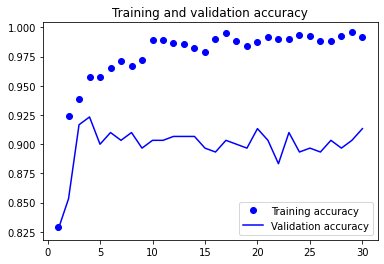

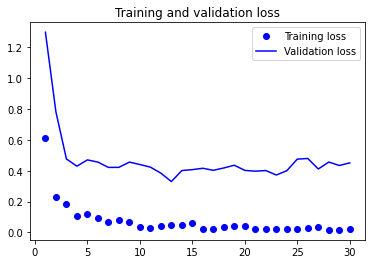

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
test_model = keras.models.load_model("feature_extraction.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

10/10 [==============================] - 5s 197ms/step - loss: 0.1533 - accuracy: 0.9567
Test accuracy: 0.957


We zien dat het ResNet50 model al heel wat beter presteert, dit had ik niet verwacht omdat EfficientNet bij binary classification beter was.

Ik zal dus dit model gebruiken om mijn voorspellingen te maken voor de paintings.

# ResNet50 finetuning

Nu zal ik ook dit model finetunen, ik zal dit doen op 4 verschillende hoeveelheden van lagen.



## 4 lagen

In [ ]:
base_model = keras.applications.ResNet50(
    include_top=False, 
    weights="imagenet",
    classes=3,
    classifier_activation="softmax")

base_model.trainable = True
for layer in base_model.layers[:-4]:
  layer.trainable = False

In [ ]:
data_augmentation = keras.Sequential(
    [layers.RandomFlip("horizontal"),
     layers.RandomRotation(0.1),
     layers.RandomZoom(0.2),])

In [ ]:
inputs = keras.Input(shape=(224, 224, 3))
x = keras.applications.resnet50.preprocess_input(inputs)
x = base_model(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(3, activation="softmax")(x)
model = keras.Model(inputs, outputs)

In [ ]:
model.compile(loss="categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

In [ ]:
callbacks = [keras.callbacks.ModelCheckpoint(
    filepath="feature_extraction.keras",
    save_best_only=True,
    monitor="val_loss")]

In [ ]:
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
38/38 [==============================] - ETA: 0s - loss: 0.6220 - accuracy: 0.8642

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


38/38 [==============================] - 20s 367ms/step - loss: 0.6220 - accuracy: 0.8642 - val_loss: 0.6486 - val_accuracy: 0.8967
Epoch 2/30
38/38 [==============================] - 14s 334ms/step - loss: 0.0622 - accuracy: 0.9758 - val_loss: 0.4688 - val_accuracy: 0.9333
Epoch 3/30
38/38 [==============================] - 14s 332ms/step - loss: 0.0231 - accuracy: 0.9933 - val_loss: 0.3719 - val_accuracy: 0.9367
Epoch 4/30
38/38 [==============================] - 14s 335ms/step - loss: 0.0231 - accuracy: 0.9917 - val_loss: 0.3470 - val_accuracy: 0.9267
Epoch 5/30
38/38 [==============================] - 14s 341ms/step - loss: 0.0056 - accuracy: 0.9992 - val_loss: 0.3259 - val_accuracy: 0.9333
Epoch 6/30
38/38 [==============================] - 13s 332ms/step - loss: 0.0128 - accuracy: 0.9933 - val_loss: 0.3053 - val_accuracy: 0.9333
Epoch 7/30
38/38 [==============================] - 13s 316ms/step - loss: 0.0091 - accuracy: 0.9983 - val_loss: 0.3235 - val_accuracy: 0.9300
Epoch 8/30

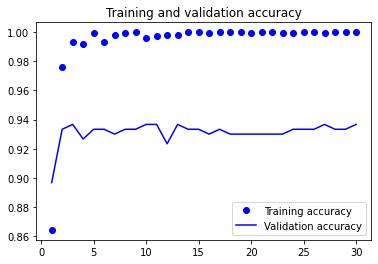

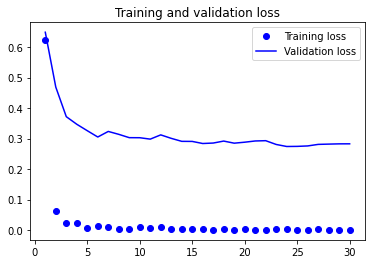

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
test_model = keras.models.load_model("feature_extraction.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

10/10 [==============================] - 4s 206ms/step - loss: 0.0836 - accuracy: 0.9567
Test accuracy: 0.957


## 8 lagen

In [ ]:
base_model = keras.applications.ResNet50(
    include_top=False, 
    weights="imagenet",
    classes=3,
    classifier_activation="softmax")

base_model.trainable = True
for layer in base_model.layers[:-8]:
  layer.trainable = False

In [ ]:
data_augmentation = keras.Sequential(
    [layers.RandomFlip("horizontal"),
     layers.RandomRotation(0.1),
     layers.RandomZoom(0.2),])

In [ ]:
inputs = keras.Input(shape=(224, 224, 3))
x = keras.applications.resnet50.preprocess_input(inputs)
x = base_model(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(3, activation="softmax")(x)
model = keras.Model(inputs, outputs)

In [ ]:
model.compile(loss="categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

In [ ]:
callbacks = [keras.callbacks.ModelCheckpoint(
    filepath="feature_extraction.keras",
    save_best_only=True,
    monitor="val_loss")]

In [ ]:
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
38/38 [==============================] - ETA: 0s - loss: 0.5818 - accuracy: 0.8633

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


38/38 [==============================] - 21s 371ms/step - loss: 0.5818 - accuracy: 0.8633 - val_loss: 0.5500 - val_accuracy: 0.9067
Epoch 2/30
38/38 [==============================] - 14s 337ms/step - loss: 0.0816 - accuracy: 0.9708 - val_loss: 0.4674 - val_accuracy: 0.9167
Epoch 3/30
38/38 [==============================] - 14s 339ms/step - loss: 0.0249 - accuracy: 0.9900 - val_loss: 0.3461 - val_accuracy: 0.9200
Epoch 4/30
38/38 [==============================] - 13s 321ms/step - loss: 0.0140 - accuracy: 0.9942 - val_loss: 0.3483 - val_accuracy: 0.9300
Epoch 5/30
38/38 [==============================] - 14s 341ms/step - loss: 0.0106 - accuracy: 0.9967 - val_loss: 0.3277 - val_accuracy: 0.9267
Epoch 6/30
38/38 [==============================] - 14s 341ms/step - loss: 0.0084 - accuracy: 0.9983 - val_loss: 0.3003 - val_accuracy: 0.9267
Epoch 7/30
38/38 [==============================] - 13s 323ms/step - loss: 0.0062 - accuracy: 1.0000 - val_loss: 0.3061 - val_accuracy: 0.9300
Epoch 8/30

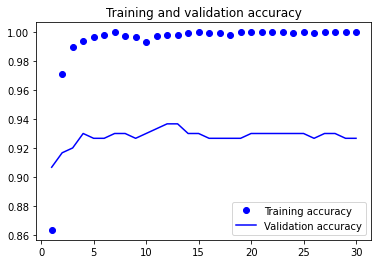

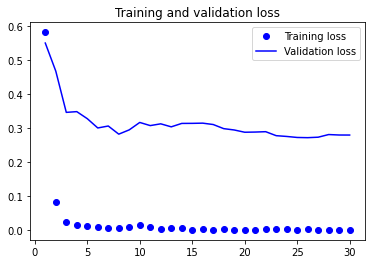

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
test_model = keras.models.load_model("feature_extraction.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

10/10 [==============================] - 4s 204ms/step - loss: 0.1074 - accuracy: 0.9633
Test accuracy: 0.963


## 12 lagen

In [ ]:
base_model = keras.applications.ResNet50(
    include_top=False, 
    weights="imagenet",
    classes=3,
    classifier_activation="softmax")

base_model.trainable = True
for layer in base_model.layers[:-12]:
  layer.trainable = False

In [ ]:
inputs = keras.Input(shape=(224, 224, 3))
x = keras.applications.resnet50.preprocess_input(inputs)
x = base_model(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(3, activation="softmax")(x)
model = keras.Model(inputs, outputs)

In [ ]:
model.compile(loss="categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

In [ ]:
callbacks = [keras.callbacks.ModelCheckpoint(
    filepath="feature_extraction.keras",
    save_best_only=True,
    monitor="val_loss")]

In [ ]:
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
38/38 [==============================] - ETA: 0s - loss: 0.6022 - accuracy: 0.8617

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


38/38 [==============================] - 20s 386ms/step - loss: 0.6022 - accuracy: 0.8617 - val_loss: 0.6624 - val_accuracy: 0.9133
Epoch 2/30
38/38 [==============================] - 14s 352ms/step - loss: 0.0935 - accuracy: 0.9617 - val_loss: 0.4331 - val_accuracy: 0.9233
Epoch 3/30
38/38 [==============================] - 14s 356ms/step - loss: 0.0435 - accuracy: 0.9850 - val_loss: 0.3239 - val_accuracy: 0.9300
Epoch 4/30
38/38 [==============================] - 16s 391ms/step - loss: 0.0113 - accuracy: 0.9975 - val_loss: 0.3107 - val_accuracy: 0.9300
Epoch 5/30
38/38 [==============================] - 19s 445ms/step - loss: 0.0061 - accuracy: 0.9983 - val_loss: 0.2780 - val_accuracy: 0.9233
Epoch 6/30
38/38 [==============================] - 17s 416ms/step - loss: 0.0099 - accuracy: 0.9958 - val_loss: 0.2900 - val_accuracy: 0.9300
Epoch 7/30
38/38 [==============================] - 17s 404ms/step - loss: 0.0062 - accuracy: 0.9983 - val_loss: 0.2779 - val_accuracy: 0.9367
Epoch 8/30

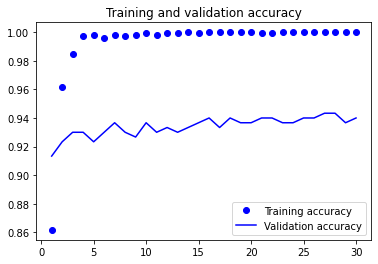

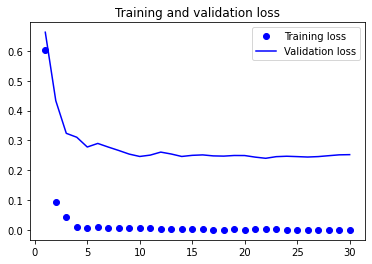

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
test_model = keras.models.load_model("feature_extraction.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

10/10 [==============================] - 4s 216ms/step - loss: 0.0832 - accuracy: 0.9667
Test accuracy: 0.967


## 16 lagen

In [ ]:
base_model = keras.applications.ResNet50(
    include_top=False, 
    weights="imagenet",
    classes=3,
    classifier_activation="softmax")

base_model.trainable = True
for layer in base_model.layers[:-16]:
  layer.trainable = False

In [ ]:
data_augmentation = keras.Sequential(
    [layers.RandomFlip("horizontal"),
     layers.RandomRotation(0.1),
     layers.RandomZoom(0.2),])

In [ ]:
inputs = keras.Input(shape=(224, 224, 3))
x = keras.applications.resnet50.preprocess_input(inputs)
x = base_model(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(3, activation="softmax")(x)
model = keras.Model(inputs, outputs)

In [ ]:
model.compile(loss="categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

In [ ]:
callbacks = [keras.callbacks.ModelCheckpoint(
    filepath="feature_extraction.keras",
    save_best_only=True,
    monitor="val_loss")]

In [ ]:
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
38/38 [==============================] - ETA: 0s - loss: 0.5216 - accuracy: 0.8525

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


38/38 [==============================] - 25s 391ms/step - loss: 0.5216 - accuracy: 0.8525 - val_loss: 0.6357 - val_accuracy: 0.9033
Epoch 2/30
38/38 [==============================] - 15s 364ms/step - loss: 0.1057 - accuracy: 0.9675 - val_loss: 0.3718 - val_accuracy: 0.9133
Epoch 3/30
38/38 [==============================] - 14s 335ms/step - loss: 0.0253 - accuracy: 0.9908 - val_loss: 0.3813 - val_accuracy: 0.9233
Epoch 4/30
38/38 [==============================] - 14s 355ms/step - loss: 0.0145 - accuracy: 0.9958 - val_loss: 0.3044 - val_accuracy: 0.9233
Epoch 5/30
38/38 [==============================] - 14s 357ms/step - loss: 0.0135 - accuracy: 0.9942 - val_loss: 0.2699 - val_accuracy: 0.9333
Epoch 6/30
38/38 [==============================] - 14s 348ms/step - loss: 0.0070 - accuracy: 0.9983 - val_loss: 0.2784 - val_accuracy: 0.9267
Epoch 7/30
38/38 [==============================] - 14s 339ms/step - loss: 0.0058 - accuracy: 0.9992 - val_loss: 0.2805 - val_accuracy: 0.9300
Epoch 8/30

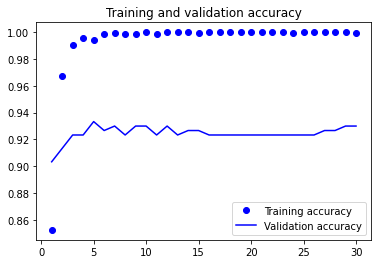

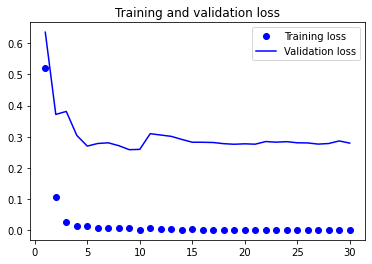

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
test_model = keras.models.load_model("feature_extraction.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

10/10 [==============================] - 5s 203ms/step - loss: 0.0964 - accuracy: 0.9600
Test accuracy: 0.960


## Besluit

* ResNet50 train last 4 layers of pretrained model: accuracy=95.67%
* ResNet50 train last 8 layers of pretrained model: accuracy=96.33%
* ResNet50 train last 12 layers of pretrained model: accuracy=96.77%
* ResNet50 train last 16 layers of pretrained model: accuracy=96%

Aan de hand van dit resultaat zien we dat het trainen van de 12 laatste lagen van het model het beste resultaat heeft.

# ResNet50 best with image_size (320,320)

In [ ]:
train_dataset = image_dataset_from_directory(
    "Picasso_Rubens_VanGogh_400_100_100/train",
    image_size=(320, 320),
    batch_size=32,
    label_mode="categorical")

validation_dataset = image_dataset_from_directory(
    "Picasso_Rubens_VanGogh_400_100_100/validation",
    image_size=(320, 320),
    batch_size=32,
    label_mode="categorical")

test_dataset = image_dataset_from_directory(
    "Picasso_Rubens_VanGogh_400_100_100/test",
    image_size=(320, 320),
    batch_size=32,
    label_mode="categorical")

Found 1200 files belonging to 3 classes.
Found 300 files belonging to 3 classes.
Found 300 files belonging to 3 classes.


In [ ]:
base_model = keras.applications.ResNet50(
    input_shape = (320, 320, 3),
    include_top=False, 
    weights="imagenet",
    classes=3,
    classifier_activation="softmax")

base_model.trainable = True
for layer in base_model.layers[:-12]:
  layer.trainable = False

In [ ]:
inputs = keras.Input(shape=(320, 320, 3))
x = keras.applications.resnet50.preprocess_input(inputs)
x = base_model(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(3, activation="softmax")(x)
model = keras.Model(inputs, outputs)

In [ ]:
model.compile(loss="categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

In [ ]:
callbacks = [keras.callbacks.ModelCheckpoint(
    filepath="feature_extraction.keras",
    save_best_only=True,
    monitor="val_loss")]

In [ ]:
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
38/38 [==============================] - ETA: 0s - loss: 0.4844 - accuracy: 0.8833

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


38/38 [==============================] - 37s 730ms/step - loss: 0.4844 - accuracy: 0.8833 - val_loss: 0.9054 - val_accuracy: 0.9000
Epoch 2/30
38/38 [==============================] - 25s 640ms/step - loss: 0.0575 - accuracy: 0.9783 - val_loss: 0.4019 - val_accuracy: 0.9367
Epoch 3/30
38/38 [==============================] - 25s 624ms/step - loss: 0.0149 - accuracy: 0.9950 - val_loss: 0.3123 - val_accuracy: 0.9433
Epoch 4/30
38/38 [==============================] - 25s 625ms/step - loss: 0.0130 - accuracy: 0.9950 - val_loss: 0.2917 - val_accuracy: 0.9433
Epoch 5/30
38/38 [==============================] - 24s 606ms/step - loss: 0.0175 - accuracy: 0.9933 - val_loss: 0.2980 - val_accuracy: 0.9400
Epoch 6/30
38/38 [==============================] - 24s 604ms/step - loss: 0.0076 - accuracy: 0.9975 - val_loss: 0.3165 - val_accuracy: 0.9400
Epoch 7/30
38/38 [==============================] - 24s 606ms/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0.3146 - val_accuracy: 0.9400
Epoch 8/30

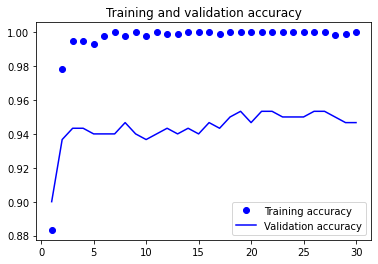

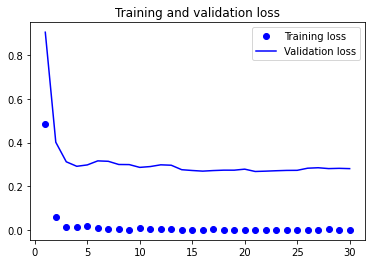

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
test_model = keras.models.load_model("feature_extraction.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

10/10 [==============================] - 6s 380ms/step - loss: 0.0929 - accuracy: 0.9533
Test accuracy: 0.953


We zien dat een grote image size geen positief effect heeft bij dit model.

#Besluit

* EfficientNet: accuracy=90.33%
* EfficientNet optimizer adam: accuracy=91.67%
* EfficientNet optimizer sgd: accuracy=92.67%
* EfficientNet batch normalization: accuracy=93.67%
* EfficientNet batch_size 64: accuracy=93.33%
* EfficientNet batch_size 16: accuracy=91.67%
* EfficientNet train last 4 layers of pretrained model: accuracy=91%
* ResNet50: accuracy=95.7%
* ResNet50 finetuning: accuracy=96.77%
* ResNet50 with image_size (320,320): accuracy=95.3%

Na al dit testen kunnen we besluiten dat het beste model bestaat uit:

1.   ResNet50
2.   optimizer -> sgd
3.   batch normalization
4.   finetuning met 12 lagen
5.   image_size -> (224,224)
6.   batch_size -> 32
